In [1]:
from kedro.framework.session import KedroSession
import matplotlib.pyplot as plt

# Preprocessing of HCL Data

This notebook serves the purpose of preprocessing HCL (Hospital Clinical Data) to create prediction models for the following health conditions over a 2-week period:

- Number of patients diagnosed with COVID-19
- Number of patients diagnosed with the flu
- Number of patients diagnosed with RSV (Respiratory Syncytial Virus)
- Number of patients diagnosed with other respiratory infections caused by various viruses
- Number of patients diagnosed with any respiratory viral infections
- Number of patient deaths for each specific disease
- Number of individuals in critical care for each specific disease

The goal of this preprocessing is to prepare the data for building predictive models that can forecast the mentioned health conditions based on historical hospital clinical data.


In [3]:
import math


### 1. Import libraries

In [31]:
import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os

### 2. Download all datasets

In [32]:
# Path to the folder containing raw data
raw_data_folder = r'C:\Users\jrubio\hcl_data\data\01_raw_data'

# Load and store DataFrames in variables based on filenames
dataframe_dict = {}  # Dictionary to store DataFrames

# Iterate through all files in the folder
for filename in os.listdir(raw_data_folder):
    if filename.endswith('.csv'):
        # Clean the filename to create a valid variable name and add "df_" prefix
        clean_filename = filename.replace(' ', '').replace('-', '_').replace('.csv', '')

        # Construct the full file path
        file_path = os.path.join(raw_data_folder, filename)

        # Load the CSV file into a DataFrame
        df = pd.read_csv(file_path, encoding='ISO-8859-1')

        # Store the DataFrame in the dictionary with the cleaned filename as key
        dataframe_dict[clean_filename] = df
        # Add the DataFrame to the global namespace
        globals()[clean_filename] = df

### 3. Dates preprocessing

In [33]:
# Get the list of DataFrame names from the keys of the dataframe_dict
dataframe_names = list(dataframe_dict.keys())

# Loop through DataFrame names
for dataframe_name in dataframe_names:
    # Retrieve the DataFrame using its name from the globals()
    df = globals()[dataframe_name]
    

    # Extract the date from the LIB_SEM column using a regular expression
    df['LIB_SEM'] = df['LIB_SEM'].str.extract(r'Du (\d{2}/\d{2}/\d{2})', expand=False)

    # Replace spaces with underscores in the 'CATEG_DIAG' column
    df['CATEG_DIAG'] = df['CATEG_DIAG'].str.replace(' ', '_')

### 4. Concatenate dataframes by type I, II & III

In [34]:
dataframes_to_concat = []  # List to store DataFrames
dataframes_to_concat_death = []  # List to store DataFrames with _II
dataframes_to_concat_critical_health = []  # List to store DataFrames with _III

In [35]:
# Loop through DataFrame names
for dataframe_name in dataframe_names:
    # Retrieve the DataFrame using its name from the globals()
    df = globals()[dataframe_name]

    # Check if the DataFrame name ends with '_I'
    if dataframe_name.endswith('_I'):
        dataframes_to_concat.append(df)
    # Check if the DataFrame name ends with '_II'
    elif dataframe_name.endswith('_II'):
        dataframes_to_concat_death.append(df)
    # Check if the DataFrame name ends with '_III'
    elif dataframe_name.endswith('_III'):
        dataframes_to_concat_critical_health.append(df)

In [36]:
# Concatenate the DataFrames in the lists vertically
df_number_of_id = pd.concat(dataframes_to_concat, ignore_index=True)
df_death = pd.concat(dataframes_to_concat_death, ignore_index=True)
df_critical_health = pd.concat(dataframes_to_concat_critical_health, ignore_index=True)
# Sort the concatenated DataFrames
df_number_of_id = df_number_of_id.sort_values(by=['NUM_SEMAINE', 'CATEG_DIAG'], ascending=[True, True]).reset_index(drop=True)
df_death = df_death.sort_values(by=['NUM_SEMAINE', 'CATEG_DIAG'], ascending=[True, True]).reset_index(drop=True)
df_critical_health = df_critical_health.sort_values(by=['NUM_SEMAINE', 'CATEG_DIAG'], ascending=[True, True]).reset_index(drop=True)

In [37]:
df_number_of_id = df_number_of_id.rename(columns={
    'DATE_EXTRACT': 'EXTRACTION_DATE',
    'CATEG_DIAG': 'DIAGNOSIS_CATEGORY',
    'ANNEE_ENTREE_RSS': 'ADMISSION_YEAR_RSS',
    'NUM_SEMAINE': 'WEEK_NUMBER',
    'LIB_SEM': 'WEEK_LABEL',
    'CLAS_AGE': 'AGE_CLASS',
    'CLAS_DUREERSS': 'RSS_DURATION_CLASS',
    'NRSS': 'TOTAL_RSS',
    'NIPP': 'NIPP'
})


df_death = df_death.rename(columns={
    'DATE_EXTRACT': 'EXTRACTION_DATE',
    'CATEG_DIAG': 'DIAGNOSIS_CATEGORY',
    'ANNEE_ENTREE_RSS': 'ADMISSION_YEAR_RSS',
    'NUM_SEMAINE': 'WEEK_NUMBER',
    'LIB_SEM': 'WEEK_LABEL',
    'DECES OU PAS (oui/non)': 'DEATH_OR_NOT',
    'NRSS': 'TOTAL_RSS',
    'NIPP': 'NIPP'
})


df_critical_health = df_critical_health.rename(columns={
    'DATE_EXTRACT': 'EXTRACTION_DATE',
    'CATEG_DIAG': 'DIAGNOSIS_CATEGORY',
    'ANNEE_ENTREE_RSS': 'ADMISSION_YEAR_RSS',
    'NUM_SEMAINE': 'WEEK_NUMBER',
    'LIB_SEM': 'WEEK_LABEL',
    'ORIG_GEO': 'GEOGRAPHICAL_ORIGIN',
    'SOINS CRITIQUES OU PAS (Oui/Non)': 'CRITICAL_CARE_OR_NOT',
    'NRSS': 'TOTAL_RSS',
    'NIPP': 'NIPP'
})

In [38]:
import pandas as pd

# Translation for CRITICAL_CARE_OR_NOT column
critical_care_translation = {'Oui': 'Yes', 'Non': 'No'}
df_critical_health['CRITICAL_CARE_OR_NOT'] = df_critical_health['CRITICAL_CARE_OR_NOT'].replace(critical_care_translation)
df_death['DEATH_OR_NOT'] = df_death['DEATH_OR_NOT'].replace(critical_care_translation)

# Translation for GEOGRAPHICAL_ORIGIN column
geographical_translation = {
    'LYON': 'LYON',
    'RHONE (HORS LYON)': 'RHONE (OUTSIDE LYON)',
    'REGION ARA (HORS RHONE)': 'AUVERGNE-RHONE-ALPES (OUTSIDE RHONE)',
    'FRANCE (HORS ARA)': 'FRANCE (OUTSIDE AUVERGNE-RHONE-ALPES)',
    'AUTRES': 'OTHER'
}
df_critical_health['GEOGRAPHICAL_ORIGIN'] = df_critical_health['GEOGRAPHICAL_ORIGIN'].replace(geographical_translation)

# Translation for DIAGNOSIS_CATEGORY column
diagnosis_translation = {
    'COVID-19': 'COVID-19',
    'GRIPPE': 'FLU',
    'IR_AUTVIRUS': 'RI_OTHER_VIRUS',
    'IR_GENERALE': 'GENERAL_RI',
    'RSV': 'RSV'
}
df_number_of_id['DIAGNOSIS_CATEGORY'] = df_number_of_id['DIAGNOSIS_CATEGORY'].replace(diagnosis_translation)
df_death['DIAGNOSIS_CATEGORY'] = df_death['DIAGNOSIS_CATEGORY'].replace(diagnosis_translation)
df_critical_health['DIAGNOSIS_CATEGORY'] = df_critical_health['DIAGNOSIS_CATEGORY'].replace(diagnosis_translation)

# Translation for AGE_CLASS column
age_class_translation = {
    'Moins de 1 an': 'Less than 1 year',
    '[1 - 5[ an(s)': '[1 - 5[ year(s)',
    '[5 - 20[ ans': '[5 - 20[ years',
    '[20 - 50[ ans': '[20 - 50[ years',
    '[50 - 65[ ans': '[50 - 65[ years',
    '65 ans et plus': '65 years and older'
}
df_number_of_id['AGE_CLASS'] = df_number_of_id['AGE_CLASS'].replace(age_class_translation)

# Translation for RSS_DURATION_CLASS column
rss_duration_translation = {
    '< 2 jours': 'Less than 2 days',
    '[2 - 5[ jours': '[2 - 5[ days',
    '5 jours et plus': '5 days and more'
}
df_number_of_id['RSS_DURATION_CLASS'] = df_number_of_id['RSS_DURATION_CLASS'].replace(rss_duration_translation)

In [43]:
df_number_of_id

,EXTRACTION_DATE,DIAGNOSIS_CATEGORY,ADMISSION_YEAR_RSS,WEEK_NUMBER,WEEK_LABEL,AGE_CLASS,RSS_DURATION_CLASS,TOTAL_RSS,NIPP
0,20/07/23,COVID-19,2Â 023,1,02/01/23,Less than 1 year,Less than 2 days,0,0
1,20/07/23,COVID-19,2Â 023,1,02/01/23,[1 - 5[ year(s),Less than 2 days,0,0
2,20/07/23,COVID-19,2Â 023,1,02/01/23,[5 - 20[ years,Less than 2 days,0,0
3,20/07/23,COVID-19,2Â 023,1,02/01/23,[20 - 50[ years,Less than 2 days,3,3
4,20/07/23,COVID-19,2Â 023,1,02/01/23,[50 - 65[ years,Less than 2 days,1,1
...,...,...,...,...,...,...,...,...,...
2119,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[1 - 5[ year(s),5 days and more,1,1
2120,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[5 - 20[ years,5 days and more,0,0
2121,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[20 - 50[ years,5 days and more,1,1
2122,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[50 - 65[ years,5 days and more,1,1


In [44]:
def process_dataframe(df):
    
    #df = df.drop(["DATE_EXTRACT", "ANNEE_ENTREE_RSS", "NRSS"], axis=1)
    # Sélectionnez les colonnes pour le groupby en excluant les colonnes spécifiées
    groupby_columns = [col for col in df.columns if col not in ['DIAGNOSIS_CATEGORY', 'NIPP']]

    # Créez un DataFrame contenant les NIPP de 'IR_GENERALE' pour chaque combinaison
    nipp_generale_par_combinaison = df[df['DIAGNOSIS_CATEGORY'] == 'IR_GENERALE'].groupby(groupby_columns)['NIPP'].sum().reset_index()
    nipp_no_generale_par_combinaison = df[df['DIAGNOSIS_CATEGORY'] != 'IR_GENERALE'].groupby(groupby_columns)['NIPP'].sum().reset_index()

    # Créez les noms de colonnes pour les résultats
    new_categ_diag_column = 'DIAGNOSIS_CATEGORY'
    new_nipp_column = 'NIPP'

    # Renommez les colonnes
    nipp_generale_par_combinaison.columns = groupby_columns + [new_nipp_column]
    nipp_no_generale_par_combinaison.columns = groupby_columns + [new_nipp_column + '_VIRAL']

    # Fusionnez les DataFrames
    result = nipp_generale_par_combinaison.merge(nipp_no_generale_par_combinaison, on=groupby_columns, how='left').fillna(0)

    # Calculez la nouvelle colonne NIPP
    result["NIPP"] = result[new_nipp_column] - result[new_nipp_column + '_VIRAL']

    # Ajoutez la colonne CATEG_DIAG
    result[new_categ_diag_column] = "IR_NON_VIRAL"

    # Concaténez avec le DataFrame d'origine
    df = pd.concat([df, result.drop([new_nipp_column + '_VIRAL'], axis=1)], ignore_index=True)

    return df

# Exemple d'utilisation pour df_number_of_id
df_number_of_id_newcat = process_dataframe(df_number_of_id)

# Exemple d'utilisation pour df_death
df_death_newcat = process_dataframe(df_death)

# Exemple d'utilisation pour df_critical_health
df_critical_health_newcat = process_dataframe(df_critical_health)

In [45]:
df_number_of_id_newcat

,EXTRACTION_DATE,DIAGNOSIS_CATEGORY,ADMISSION_YEAR_RSS,WEEK_NUMBER,WEEK_LABEL,AGE_CLASS,RSS_DURATION_CLASS,TOTAL_RSS,NIPP
0,20/07/23,COVID-19,2Â 023,1,02/01/23,Less than 1 year,Less than 2 days,0,0
1,20/07/23,COVID-19,2Â 023,1,02/01/23,[1 - 5[ year(s),Less than 2 days,0,0
2,20/07/23,COVID-19,2Â 023,1,02/01/23,[5 - 20[ years,Less than 2 days,0,0
3,20/07/23,COVID-19,2Â 023,1,02/01/23,[20 - 50[ years,Less than 2 days,3,3
4,20/07/23,COVID-19,2Â 023,1,02/01/23,[50 - 65[ years,Less than 2 days,1,1
...,...,...,...,...,...,...,...,...,...
2119,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[1 - 5[ year(s),5 days and more,1,1
2120,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[5 - 20[ years,5 days and more,0,0
2121,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[20 - 50[ years,5 days and more,1,1
2122,20/07/23,GENERAL_RI,2Â 023,28,10/07/23,[50 - 65[ years,5 days and more,1,1


### 5. Select columns

In [40]:
df_number_of_id_by_age = df_number_of_id[ ["DIAGNOSIS_CATEGORY", "LIB_SEM", "CLAS_AGE", "NUM_SEMAINE", "NIPP"]]

df_number_of_id_clean = df_number_of_id[ ["DIAGNOSIS_CATEGORY", "LIB_SEM", "NUM_SEMAINE", "NIPP"]]
df_death = df_death[ ["DIAGNOSIS_CATEGORY", "LIB_SEM", "NUM_SEMAINE", "DECES OU PAS (oui/non)","NIPP"]]
df_critical_health = df_critical_health[ ["DIAGNOSIS_CATEGORY", "LIB_SEM", "NUM_SEMAINE", "SOINS CRITIQUES OU PAS (Oui/Non)","NIPP"]]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df_number_of_id_by_age = df_number_of_id[ ["CATEG_DIAG", "LIB_SEM", "CLAS_AGE", "NUM_SEM     │
│   2                                                                                              │
│   3 df_number_of_id_clean = df_number_of_id[ ["CATEG_DIAG", "LIB_SEM", "NUM_SEMAINE", "NIPP"     │
│   4 df_death = df_death[ ["CATEG_DIAG", "LIB_SEM", "NUM_SEMAINE", "DECES OU PAS (oui/non)","     │
│                                                                                                  │
│ c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\pandas\core\frame.py:3767 in   │
│ __getitem__                                                                                      │
│                                                                                                  │
│ c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\pandas\core\indexes\base.py:58 │
│ 77 in _get_indexer_strict                                                                        │
│                                                                                                  │
│ c:\ProgramData\Anaconda3\envs\kedro-environment\lib\site-packages\pandas\core\indexes\base.py:59 │
│ 41 in _raise_if_missing                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: "['CATEG_DIAG', 'LIB_SEM', 'CLAS_AGE', 'NUM_SEMAINE'] not in index"

### 6. Aggregate

In [41]:
df_agg_number_of_id = df_number_of_id_clean.groupby(['NUM_SEMAINE', 'CATEG_DIAG'])['NIPP'].sum().reset_index().rename(columns={'NIPP': 'Nb_of_patient'})
df_agg_death = df_death.groupby(['NUM_SEMAINE', 'CATEG_DIAG','DECES OU PAS (oui/non)'])['NIPP'].sum().reset_index().rename(columns={'NIPP': 'Death_patients'})
df_agg_critical_health = df_critical_health.groupby(['NUM_SEMAINE', 'CATEG_DIAG','SOINS CRITIQUES OU PAS (Oui/Non)'])['NIPP'].sum().reset_index().rename(columns={'NIPP': 'Critical_health_patients'})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df_agg_number_of_id = df_number_of_id_clean.groupby(['NUM_SEMAINE', 'CATEG_DIAG'])['NIPP     │
│   2 df_agg_death = df_death.groupby(['NUM_SEMAINE', 'CATEG_DIAG','DECES OU PAS (oui/non)'])[     │
│   3 df_agg_critical_health = df_critical_health.groupby(['NUM_SEMAINE', 'CATEG_DIAG','SOINS      │
│   4                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'df_number_of_id_clean' is not defined

### 7. Merge

In [351]:
final_df = df_agg_number_of_id.merge(df_agg_death, on=['NUM_SEMAINE', 'CATEG_DIAG'], how='left')
final_df = final_df.merge(df_agg_critical_health, on=['NUM_SEMAINE', 'CATEG_DIAG'], how='left')
final_df.to_csv('C:/Users/jrubio/hcl-model-project/data/05_model_input/final_df.csv', index=False)

### 8. Graphs

In [352]:
df_number_of_id_by_age

,CATEG_DIAG,LIB_SEM,CLAS_AGE,NUM_SEMAINE,NIPP
0,COVID-19,02/01/23,Moins de 1 an,1,0.0
1,COVID-19,02/01/23,[1 - 5[ an(s),1,0.0
2,COVID-19,02/01/23,[5 - 20[ ans,1,0.0
3,COVID-19,02/01/23,[20 - 50[ ans,1,3.0
4,COVID-19,02/01/23,[50 - 65[ ans,1,1.0
...,...,...,...,...,...
2623,IR_NON_VIRAL,10/07/23,[5 - 20[ ans,28,2.0
2624,IR_NON_VIRAL,10/07/23,[5 - 20[ ans,28,1.0
2625,IR_NON_VIRAL,10/07/23,[50 - 65[ ans,28,1.0
2626,IR_NON_VIRAL,10/07/23,[50 - 65[ ans,28,0.0


<Figure size 800x600 with 0 Axes>

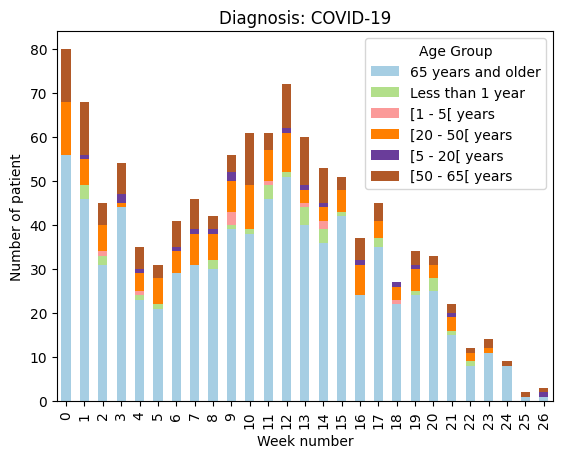

<Figure size 800x600 with 0 Axes>

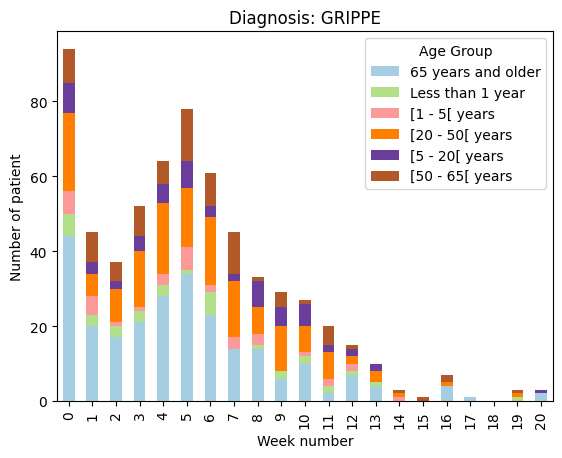

<Figure size 800x600 with 0 Axes>

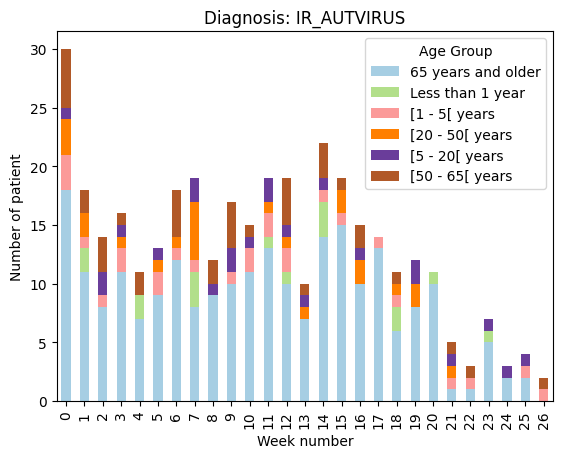

<Figure size 800x600 with 0 Axes>

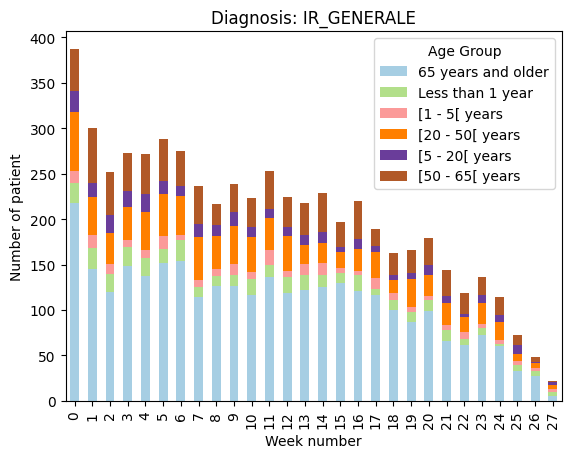

<Figure size 800x600 with 0 Axes>

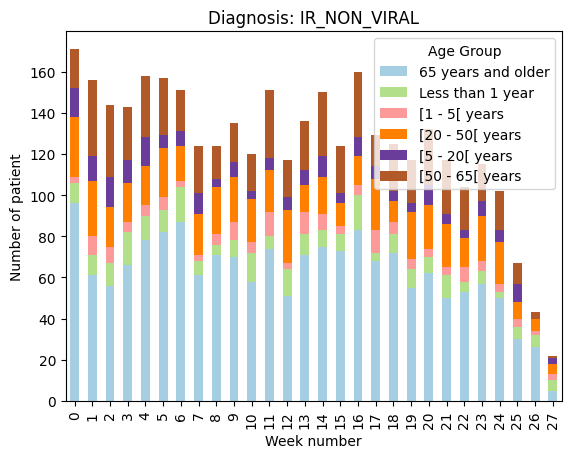

<Figure size 800x600 with 0 Axes>

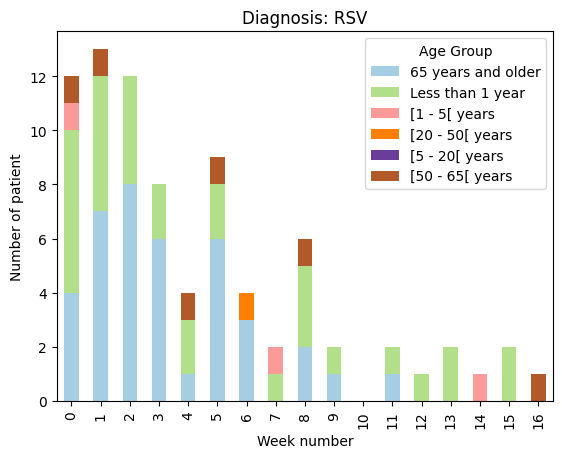

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns

df_number_of_id_by_age_group = df_number_of_id_by_age.groupby(['NUM_SEMAINE', 'CATEG_DIAG','CLAS_AGE'])['NIPP'].sum().reset_index().rename(columns={'NIPP': 'Nb_of_patient'})

# Map of age category translations
age_category_translation = {
    'Moins de 1 an': 'Less than 1 year',
    '[1 - 5[ an(s)': '[1 - 5[ years',
    '[5 - 20[ ans': '[5 - 20[ years',
    '[20 - 50[ ans': '[20 - 50[ years',
    '[50 - 65[ ans': '[50 - 65[ years',
    '65 ans et plus': '65 years and older'
}


df = df_number_of_id_by_age_group

# Replace the original 'CLAS_AGE' values with their English translations
df['CLAS_AGE'] = df['CLAS_AGE'].map(age_category_translation)

# Pivot the DataFrame to have AGE groups as columns
pivot_df = df.pivot(index=['CATEG_DIAG', 'NUM_SEMAINE'], columns='CLAS_AGE', values='Nb_of_patient').reset_index()

# Define the order of AGE levels
custom_age_order = df['CLAS_AGE'].unique()[[1,2,4,3,5,0]]
age_order = df['CLAS_AGE'].unique()
# Create a list of unique CAT_DIAG values
cat_diag_values = df['CATEG_DIAG'].unique()

# Define the complete list of weeks (assuming weeks range from 1 to N)

# Iterate over CAT_DIAG values and create a bar plot for each
for cat_diag in cat_diag_values:
    
    # Filter the pivoted DataFrame for the current CAT_DIAG
    cat_diag_df = pivot_df[pivot_df['CATEG_DIAG'] == cat_diag]
    
    complete_weeks = range(1, max(cat_diag_df["NUM_SEMAINE"]) + 1)
    
    # Reindex the DataFrame with the complete list of weeks and fill missing values with 0
    cat_diag_df = cat_diag_df.set_index('NUM_SEMAINE').reindex(complete_weeks, fill_value=0).reset_index()
    
    # Create a new figure for each plot
    plt.figure(figsize=(8, 6))
    
    # Create a stacked bar plot for the current CAT_DIAG
    ax = cat_diag_df.plot.bar(
        x='NUM_SEMAINE',
        stacked=True,
        colormap='Paired',
        xticks=cat_diag_df.index,  # Set x-axis ticks
        xlabel='Week number',
        ylabel='Number of patient',
        title=f'Diagnosis: {cat_diag}',
    )
    
    # Set the custom order of AGE levels for the legend
    ax.legend(title='Age Group', labels=pd.Categorical(age_order, categories=custom_age_order, ordered=True))
    
    # Show the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your prepared DataFrame
# You may need to adjust column names according to your DataFrame

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define the order of AGE levels
age_order = df['CLAS_AGE'].unique()[[0, 5, 3, 4, 2, 1]]

# Create a bar plot using seaborn
sns.barplot(
    data=df,
    x='NUM_SEMAINE',
    y='n',
    hue='AGE',
    palette='Paired',
    hue_order=age_order,
    ax=ax
)

# Set the title and labels
ax.set_title("Number of RSS by Week and Age Group")
ax.set_xlabel("Week number")
ax.set_ylabel("Number of RSS")
ax.legend(title="Age Group")

# Adjust facet plot for CATEG_DIAG
g = sns.FacetGrid(df, col='CATEG_DIAG', margin_titles=True, col_wrap=3)
g.map_dataframe(sns.barplot, x='NUM_SEMAINE', y='n', hue='AGE', palette='Paired', hue_order=age_order)
g.set_axis_labels("Week number", "Number of RSS")
g.set_titles(col_template="{col_name}")

# Show the plot
plt.tight_layout()
plt.show()

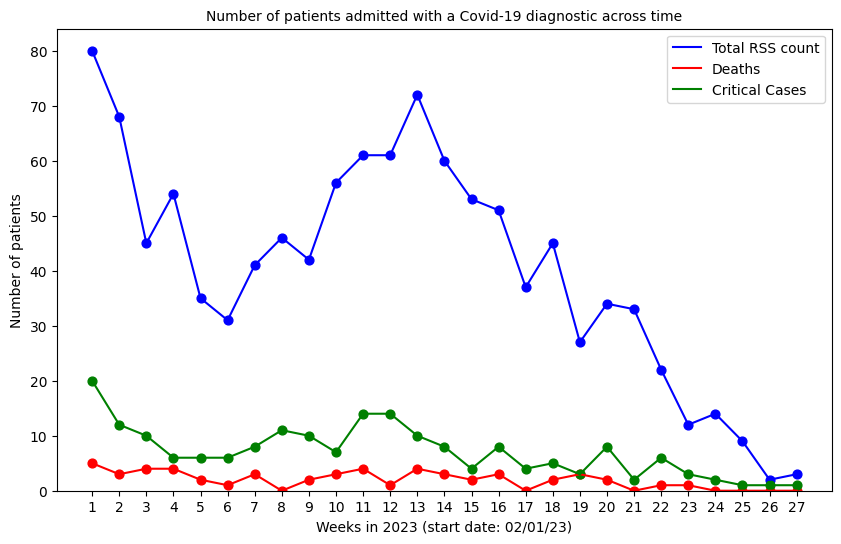

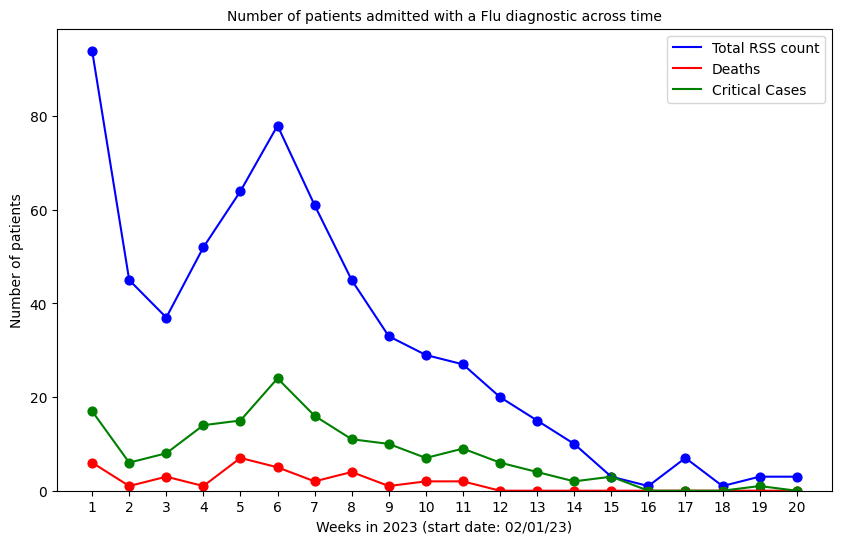

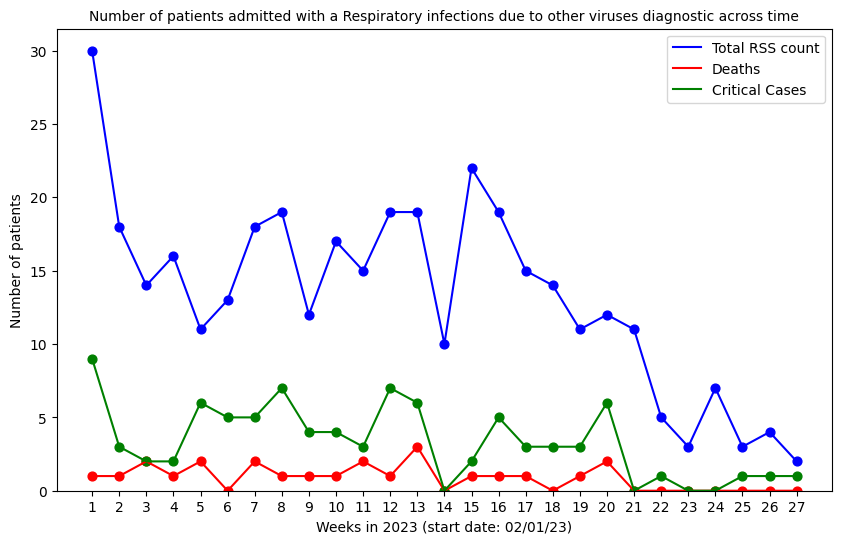

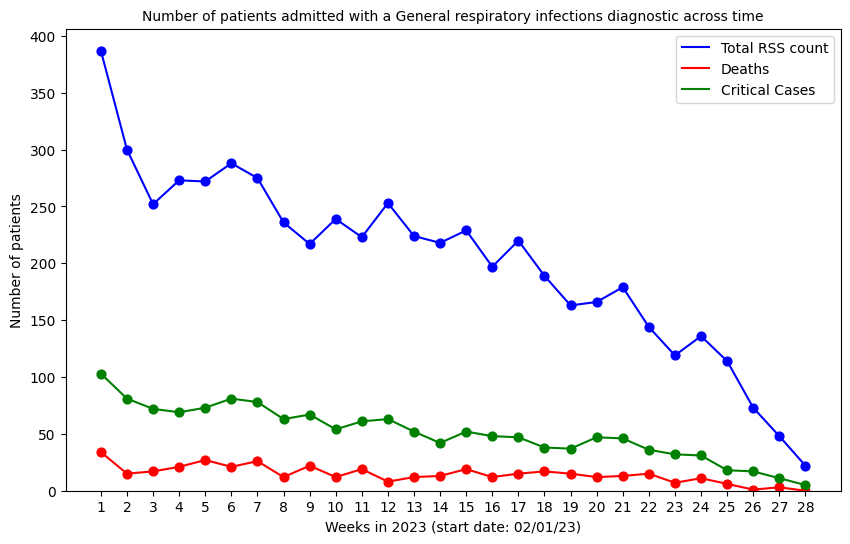

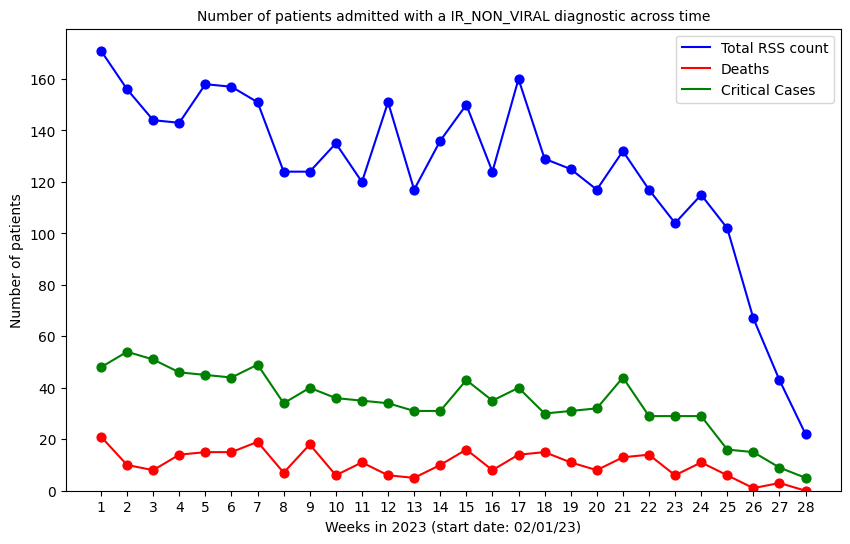

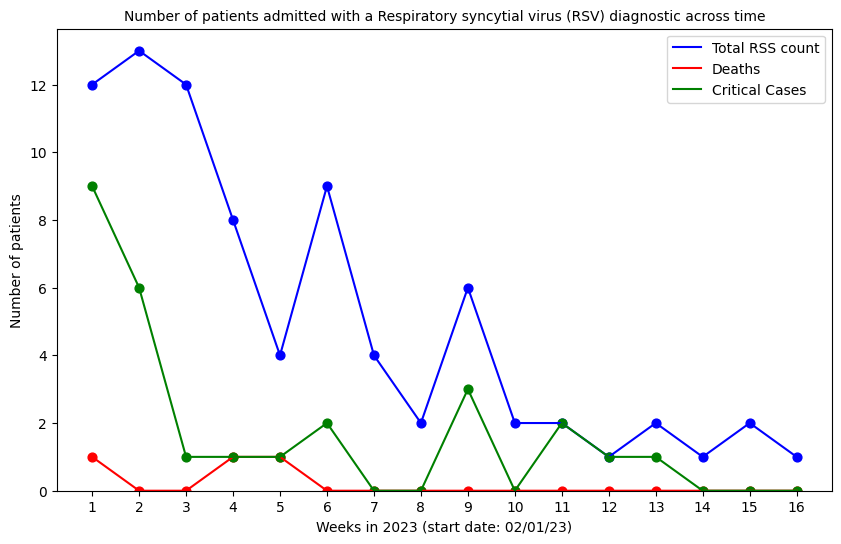

In [354]:
import numpy as np
import matplotlib.pyplot as plt

# Define dataframe data
final_df.columns = ['NUM_SEMAINE', 'CATEG_DIAG', 'NB_PATIENTS', 'IS_DEATH', 'NB_IS_DEATH', 'IS_CRITIC', 'NB_IS_CRITIC']
filtered_df = final_df[(final_df['IS_DEATH'] == 'Oui') & (final_df['IS_CRITIC'] == 'Oui')].drop(['IS_DEATH', 'IS_CRITIC'], axis=1)

# Get unique disease categories
disease_categories = filtered_df['CATEG_DIAG'].unique()

# Define custom disease labels
disease_labels = {
    'COVID-19': 'Covid-19',
    'GRIPPE': 'Flu',
    'IR_AUTVIRUS': 'Respiratory infections due to other viruses',
    'IR_GENERALE': 'General respiratory infections',
    'RSV': 'Respiratory syncytial virus (RSV)'
}

# Define selected parameters
selected_parameters = ['NB_PATIENTS', 'NB_IS_DEATH', 'NB_IS_CRITIC']

# Create a color map to assign different colors to different parameters
colors = ['blue', 'red', 'green']  # You can add more colors as needed

# Loop over each disease category
for selected_disease in disease_categories:
    # Extract data for the selected disease
    disease_data = filtered_df[filtered_df['CATEG_DIAG'] == selected_disease]
    
    # Create a new figure
    plt.figure(figsize=(10, 6))
    
    # Loop over each selected parameter and corresponding color
    for i, selected_parameter in enumerate(selected_parameters):
        observed_data = disease_data[selected_parameter]
        
        # Plot the observed data for the current parameter with the assigned color
        plt.plot(range(1, len(observed_data) + 1), observed_data, label=f'{selected_parameter}', color=colors[i])
        
        # Add points where there is data without a label in the legend
        plt.scatter(range(1, len(observed_data) + 1), observed_data, color=colors[i], marker='o', s=40, label='_nolegend_')
    
    # Customize the disease label using the dictionary
    custom_disease_label = disease_labels.get(selected_disease, selected_disease)
    
    plt.title(f"Number of patients admitted with a {custom_disease_label} diagnostic across time", fontsize = 10)
    plt.xlabel("Weeks in 2023 (start date: 02/01/23)")
    plt.ylabel("Number of patients")
    
    # Customizing the legend labels
    legend_labels = ['Total RSS count', 'Deaths', 'Critical Cases']  # Customize these labels as needed
    
    # Create a legend with custom labels
    plt.legend(legend_labels)
    
    plt.ylim(bottom=0)
    plt.xticks(range(1, len(disease_data) + 1))
    
    plt.show()

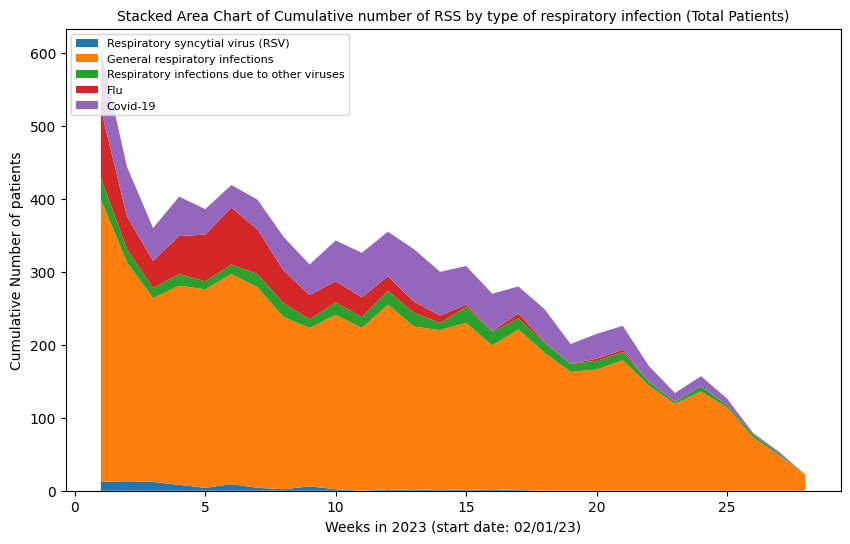

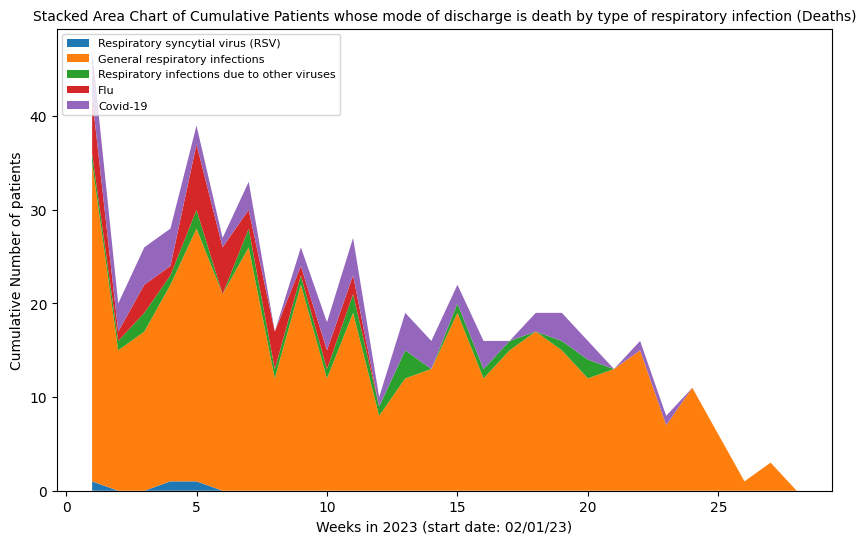

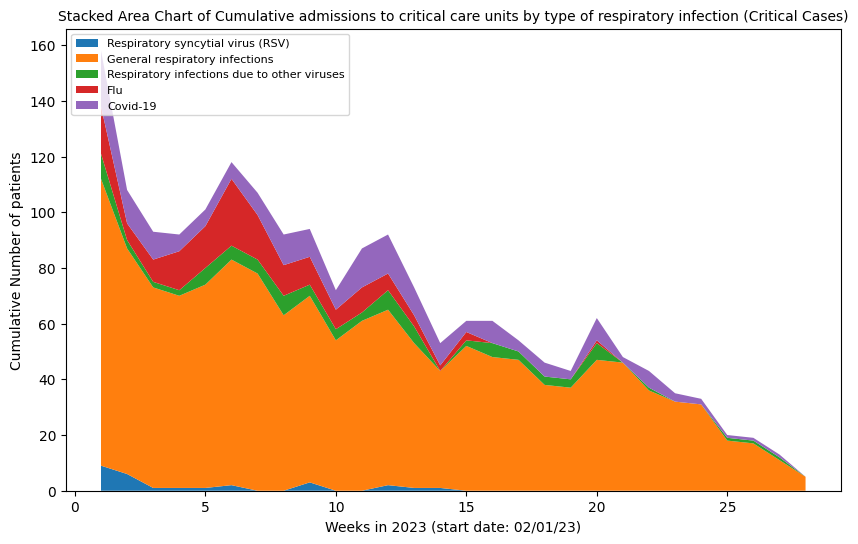

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Define dataframe data
final_df.columns = ['NUM_SEMAINE', 'CATEG_DIAG', 'NB_PATIENTS', 'IS_DEATH', 'NB_IS_DEATH', 'IS_CRITIC', 'NB_IS_CRITIC']
filtered_df = final_df[(final_df['IS_DEATH'] == 'Oui') & (final_df['IS_CRITIC'] == 'Oui')].drop(['IS_DEATH', 'IS_CRITIC'], axis=1)

# Get unique disease categories
disease_categories = filtered_df['CATEG_DIAG'].unique()

# Get unique weeks (dates)
weeks = filtered_df['NUM_SEMAINE'].unique()

# Define custom disease labels
disease_labels = {
    'COVID-19': 'Covid-19',
    'GRIPPE': 'Flu',
    'IR_AUTVIRUS': 'Respiratory infections due to other viruses',
    'IR_GENERALE': 'General respiratory infections',
    'RSV': 'Respiratory syncytial virus (RSV)'
}

# Define custom parameter labels
legend_labels = ['Total', 'Deaths', 'Critical Cases']

# Define selected parameters
selected_parameters = ['NB_PATIENTS', 'NB_IS_DEATH', 'NB_IS_CRITIC']

# Loop over each selected parameter
for selected_parameter in selected_parameters:
    # Create an empty dictionary to store cumulative data for each disease
    cumulative_data_dict = {}

    # Loop over each disease category
    for disease_category in reversed(disease_categories):  # Reverse the order of disease categories
        cumulative_data = []
        # Loop over each week
        for week in weeks:
            # Filter data for the current disease category, week, and selected parameter
            disease_data = filtered_df[(filtered_df['CATEG_DIAG'] == disease_category) & (filtered_df['NUM_SEMAINE'] == week)]
            # Calculate cumulative data for the selected parameter
            cumulative_value = sum(disease_data[selected_parameter])
            cumulative_data.append(cumulative_value)
        # Store cumulative data in the dictionary with the disease category as the key
        cumulative_data_dict[disease_category] = cumulative_data

    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Create a baseline array for stacking
    baseline = np.zeros(len(weeks))

    # Plot cumulative data as a stacked area chart
    for disease_category in reversed(disease_categories):  # Reverse the order again for the legend
        cumulative_data = cumulative_data_dict[disease_category]
        plt.fill_between(weeks, baseline + cumulative_data, baseline, label=f'{disease_labels.get(disease_category, disease_category)}')
        baseline += cumulative_data

    plt.xlabel("Weeks in 2023 (start date: 02/01/23)")
    plt.ylabel(f"Cumulative Number of patients")

    # Customize legend labels
    legend_labels = [f'{disease_labels.get(disease_category, disease_category)} ({selected_parameter.replace("_", " ")})' for disease_category in reversed(disease_categories)]

    # Create a legend with custom labels
    plt.legend(loc='upper left', fontsize=8)
    if selected_parameter == 'NB_PATIENTS':
        title = "Stacked Area Chart of Cumulative number of RSS by type of respiratory infection (Total Patients)"
    elif selected_parameter == 'NB_IS_DEATH':
        title = "Stacked Area Chart of Cumulative Patients whose mode of discharge is death by type of respiratory infection (Deaths)"
    elif selected_parameter == 'NB_IS_CRITIC':
        title = "Stacked Area Chart of Cumulative admissions to critical care units by type of respiratory infection (Critical Cases)"
    else:
        title = ""

    plt.title(title, fontsize=10)
    plt.ylim(bottom=0)

    plt.show()